**Chapter 4 – Training Models**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/machinelearning/blob/main/040-training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

- So far we have treated Machine Learning models and their training algorithms mostly like black boxes.
- Having a good understanding of how things work can help you quickly home in on the appropriate model, the right training algorithm to use, and a good set of hyperparameters for your task.
- Most of the topics discussed in this chapter will be essential in understanding, building, and training neural networks


***Content***
1. Linear Regression
2. Polynomial Regression.
3. Regularized Linear Models
4. Logistic Regression.


# 0. Setup Python

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 1. Linear Regression

In Chapter 1 we looked at a simple regression model of life satisfaction:

$$
LifeSatisfaction = θ_0 + θ_1 × GDPPerCapita
$$

More generally: 

$$
\hat{y} = θ_0 + θ_1x_1 + θ_2x_2 +⋯+ θ_nx_n
$$

In this equation: 

- $\hat{y}$ is the predicted value.
- $n$ is the number of features.
- $x_i$ is the i<sup>th</sup> feature value.
- $\theta_j$ is the j<sup>th</sup> model parameter (including the bias term θ<sub>0</sub> and the feature weights θ<sub>1</sub>, θ<sub>2</sub>, ⋯, θ<sub>n</sub>).

This can be written much more concisely using a vectorized form as:

$$
\hat{y} = h_0(\mathbf{x})  = \mathbf{θ} \cdot \mathbf{x}
$$

In this equation:
- $\mathbf{θ}$ is the model’s parameter vector, containing the bias term _θ<sub>0</sub>_ and the feature weights _θ<sub>1</sub>_ to _θ<sub>n</sub>_.
- $\mathbf{x}$ is the instance’s feature vector, containing x<sub>0</sub> to x<sub>n</sub> , with x<sub>0</sub> always equal to 1.
- $\mathbf{θ} \cdot \mathbf{x}$ is the dot product of the vectors $\mathbf{θ}$ and $\mathbf{x}$, which is equal to $θ_0x_0 + θ_1x_1 + θ_2x_2 +⋯+ θ_nx_n$.
- $h$ is the hypothesis function, using the model parameters $\mathbf{θ}$.

In Machine Learning, vectors are often represented as column vectors, which are 2D
arrays with a single column. If $\mathbf{θ}$ and $\mathbf{x}$ are column vectors, then the prediction is
$\hat{y} = \mathbf{θ}^T\mathbf{x}$, where $\mathbf{θ}^T$ is the transpose of $\mathbf{θ}$ (a row vector instead of a column vector) and
$\mathbf{θ}^T\mathbf{x}$ is the matrix multiplication of $\mathbf{θ}^T$ and $\mathbf{x}$. It is of course the same prediction, except
that it is now represented as a single-cell matrix rather than a scalar value. In this course we
will use this notation to avoid switching between dot products and matrix
multiplications.  

To train a Linear Regression model, we need to find the value of $\mathbf{θ}$ that minimizes the RMSE. In practice, it is simpler to minimize the mean squared error (MSE) than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root). 

The MSE of a Linear Regression hypothesis $h_θ$ on a training set $\mathbf{X}$ is calculated using the equation 

$$
MSE(\mathbf{X},h_θ) = \frac{1}{m}\sum_{i=1}^{m}(\mathbf{θ}^T \mathbf{x}^{(i)} - {y}^{(i)} )^2
$$

with $m$ the number of instances in the training set. 






Let's plot some linear-looking data to test the algorithms on. 

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

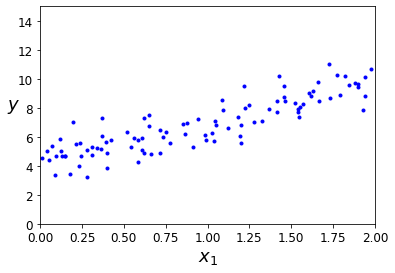

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple:

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

It's easy to visualize the fitted line: just predict two x values

In [55]:
X_new = np.array([[0], [2]])
y_predict = lin_reg.predict(X_new)

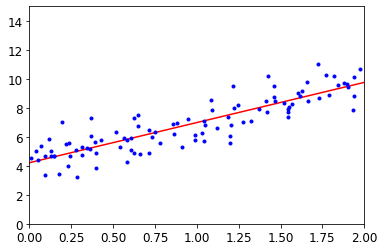

In [56]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares", which refers to MSE). 

## Computational Complexity

The approach used by Scikit-Learn’s LinearRegression class is about $O(n^2)$. **If you double the number of features, you multiply the computation time by roughly 4**. It gets very slow when the number of features grows large (e.g., 100,000). On the positive side, **it is linear with regard to the number of instances** in the training set ($O(m)$), so it handles large training sets efficiently, provided they can fit in memory.

Also, **once you have trained your Linear Regression model, predictions are very fast: the computational complexity is linear with regard to both the number of
instances you want to make predictions on and the number of features**. In other words, making predictions on twice as many instances (or twice as
many features) will take roughly twice as much time. 

Now we will look at a very different way to train a Linear Regression model, which is better suited for cases where there are a large number of features or
too many training instances to fit in memory.

# Gradient Descent
_Gradient Descent_ is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient
Descent is to tweak parameters iteratively in order to minimize a cost function.

Concretely, you start by filling $\mathbf{θ}$ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum. The learning step size is proportional to
the slope of the cost function, so the steps gradually get smaller as the parameters approach the
minimum

![](img/gradient_descent.png)

An important parameter in Gradient Descent is the size of the steps, determined by the _learning rate_ hyperparameter:  
- If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
- If the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before.


## Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter $θ_j$. 
- In other words, you need to calculate how much the cost function will change if you change $θ_j$ just a little bit.
- This is called a _partial derivative_. It is like asking “What is the slope of the mountain under my feet if I face east?” and then asking the
same question facing north (and so on for all other dimensions). 

Notice that this approach involves calculations over the full training set X, at each Gradient Descent step! This is why the algorithm is called Batch Gradient Descent: 
- It uses the whole batch of training data at every step. 
- As a result it is terribly slow on very large training sets.


## Stochastic Gradient Descent

To overcome the problem of training the whole batch at every step, _Stochastic Gradient Descent_ picks a random instance in the training set at every step
and computes the gradients based only on that single instance.

- This makes the algorithm much faster because it has very little data to manipulate at every iteration.
- It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration. 
- On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently
decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average:

![](img/sgd.png)

In practice, with stochastic gradient descent we go through a number of rounds (called _epochs_). 
- In each epoch we iterate through $m$ (= number of instances in the training set) randomly selected instances. 
- At each such an iteration we calculate the gradient and try to approach the minimum a bit closer. 

**The number of epochs is an important hyperparameter for algorithms that use stochastic gradient descent.**

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared
error cost function. The following code runs for maximum 1,000 epochs or until the loss drops by less than 0.001 during one epoch (`max_iter=1000,
tol=1e-3`). It starts with a learning rate of 0.1 (`eta0=0.1`). Lastly, it does not use
any regularization (penalty=None; more details on this shortly):

In [57]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())  # sgd_reg.fit expects a 1d array as its 2nd parameter iso of a column vector, hence y.ravel()

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [58]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

This is very close to the result of the linear regression above. 

# 2. Polynomial Regression

What if your data is more complex than a straight line? 
- you can use a linear model to fit nonlinear data
- add powers of each feature as new features
- then train a linear model on this extended set of features. 
This technique is called _Polynomial Regression_.

In [59]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [60]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

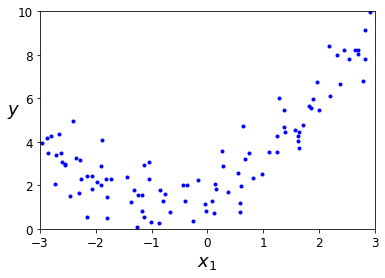

In [61]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [62]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [63]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of X plus the square of this feature. Now you can fit a `LinearRegression` model to this extended training data:

In [64]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

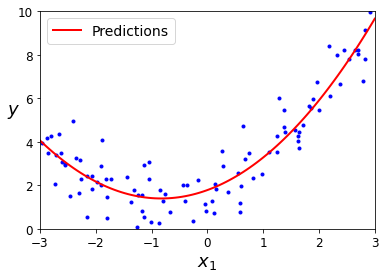

In [65]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Not bad: the model estimates $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$ when in fact the original function was $y = 0.5x_1^2 + 1.0x_1 + 2.0$ + Gaussian noise. 

Note that when there are multiple features (e.g. $x_1$ and $x_2$), Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact that `PolynomialFeatures` also adds all combinations of features up to the given
degree. For example, if there were two features $a$ and $b$, `PolynomialFeatures` with degree=3 would not only add the features $a^2$, $a^3$, $b^2$ and $b^3$, but also the combinations $ab$, $a^2 b$, and $ab^2$.

High-degree Polynomial Regression can fit the training data much better than plain Linear Regression.

In the figure below we fit a 300-degree polynomial, a quadratic model (second degree) and a pure linear model (first degree) through the training set. 

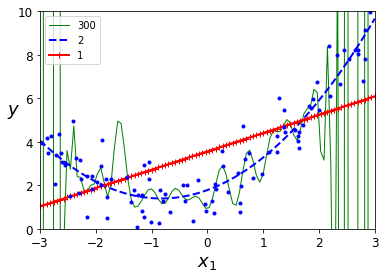

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

- The high-degree Polynomial Regression model is severely overfitting the training data.
- The linear model is underfitting it.

# 3. Regularized Linear Models

- A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. 
- A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.
- For a linear model, regularization is typically achieved by constraining the weights of the model.

## Ridge Regression

Ridge Regression is a regularized version of Linear Regression: a regularization term is added to the cost function.

$$
J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2
$$

The hyperparameter *α* controls how much you want to regularize the model.
- If *α = 0*, then Ridge Regression is just Linear Regression. 
- If *α* is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

Note that the bias term $θ_0$ is not regularized (the sum starts at *i = 1*, not *0*).

**WARNING**  
It is important to scale the data (e.g., using a StandardScaler) before performing
Ridge Regression, as it is sensitive to the scale of the input features. This is true for most regularized models.

The figures below show several Ridge models trained on some linear data using different $α$ values.

In [67]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [68]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [69]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

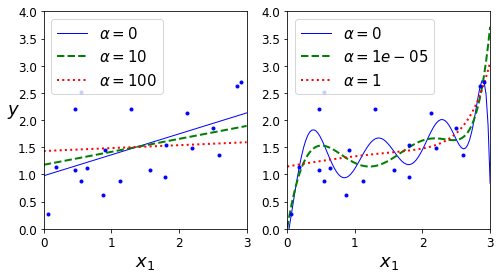

In [70]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

Note how increasing $α$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing overfitting. 

# 4. Logistic Regression

 - Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). 
 - If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). 
 - This makes it a binary _classifier_ (although it is a _regression_ algorithm).

 ## Estimating probabilities

 Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result.

 $$
 \hat{p} = h_{\theta}(x) = \sigma(\mathbf{x^T}\mathbf{\theta})
 $$

 where, as we have seen before, 

 $$
\mathbf{x^T}\mathbf{\theta} = θ_0x_0 + θ_1x_1 + θ_2x_2 +⋯+ θ_nx_n 
 $$
 with $x_0 = 1$

 The logistic—noted $σ(·)$— is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1. It is defined as:

$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

![](img/logistic_function_plot.png)

Once the Logistic Regression model has estimated the probability $\hat{p} = h_{\theta}(x)$ that an instance $\mathbf{x}$ belongs to the positive class, it can make its prediction $ŷ$
easily:

$\hat{y} = 0$  if  $\hat{p} < 0.5$   

$\hat{y} = 1$  if  $\hat{p} \ge 0.5$


The way a logistic regression model is trained is outside the scope of this course but again it comes down to searching the minimum of a cost function. 

## Decision Boundaries
Let’s use the iris dataset to illustrate Logistic Regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers
of three different species: Iris setosa, Iris versicolor, and Iris virginica.  
 
![](img/iris.png)

Let’s try to build a classifier to detect the Iris virginica type based only on the petal width feature. First let’s load the data:

In [72]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [73]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [74]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

<ipython-input-74-c3494bf9af66>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0


Now let’s train a Logistic Regression model.   

In [75]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

Let’s look at the model’s **estimated probabilities** for flowers with **petal widths varying from 0 cm to 3 cm**.

[[9.99250016e-01 7.49984089e-04]
 [9.99240201e-01 7.59799387e-04]
 [9.99230257e-01 7.69743043e-04]
 ...
 [3.08374822e-03 9.96916252e-01]
 [3.04400296e-03 9.96955997e-01]
 [3.00476842e-03 9.96995232e-01]]


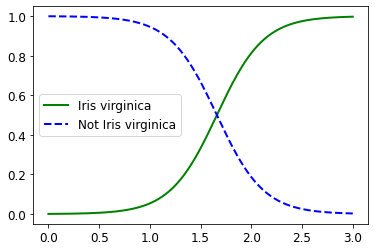

In [76]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # generate random petal widths
y_proba = log_reg.predict_proba(X_new)
print(y_proba) # y_proba is a matrix showing probalites 

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.legend(loc="center left", fontsize=12)

The figure in the book actually is actually a bit fancier:
![](img/logistic_regression_plot.png)

Observations:
- The petal width of Iris virginica flowers (represented by triangles) ranges from 1.4 cm to 2.5 cm
- The other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm. 
- There is a bit of overlap. 
- Above about 2 cm the classifier is highly confident that the flower is an Iris virginica (it outputs a high probability for that class). 
- Below 1 cm it is highly confident that it is not an Iris virginica (high probability for the “Not Iris virginica” class). 
- In between these extremes, the classifier is unsure. 
- However, if you ask it to predict the class (using the predict() method rather than the predict_proba() method), it will return whichever class is the most likely.  
- Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is higher than 1.6 cm, the classifier will predict that the flower is an Iris virginica, and otherwise it will predict that it is not (even if it is not very confident):

In [77]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

No suppose the case of more than one input feature:
- The figure below shows the same dataset, but this time displaying two features: petal width and length. 
- Once trained, the Logistic Regression classifier can, based on these two features, estimate the probability that a new flower is an Iris virginica. 
- The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary: it is a linear boundary. 
- Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). 
- All the flowers beyond the top-right line have an over 90% chance of being Iris virginica, according to the model.




![](img/logistic_regression_contour_plot.png)

## Softmax Regression

- The Logistic Regression model can be generalized to **support multiple classes directly**, without having to train and combine multiple binary
classifiers (as discussed in Chapter 3). 
- This is called _Softmax Regression_, or _Multinomial Logistic Regression_.

The idea is simple: when given an instance $\mathbf{x}$, the Softmax Regression model first computes a score $s_k(x)$ for each class $k$, then estimates the probability of
each class by applying the _softmax function_.

The equation to compute $s_k(x)$ for class $k$ should look familiar, as it is just like the equation for Linear Regression prediction:

$$
s_k(x) = \mathbf{x^T}\mathbf{\theta}^{(k)}
$$

where $\mathbf{\theta}^{(k)}$ is the dedicated parameter vector for class $k$. 

- Once you have computed the score of every class for the instance $\mathbf{x}$, you can estimate the probability $\hat{p}$ that the instance belongs to class $k$ by running the scores through the softmax function. 
- This function computes the  exponential of every score, then normalizes them (dividing by the sum of all the exponentials to ensure the probabilities for all class sum up to one):
$$
\hat{p}_k = \mathbf{\sigma}(\mathbf{s(x)})_k = \frac{exp(s_k(x))}{\sum_{j=1}^{K}exp(s_j(\mathbf{x}))}
$$
with:
- $K$ the number of classes
- $\mathbf{s(x)}$ a vector containing the scores of each class for the instance $\mathbf{x}$.
- $\mathbf{\sigma}(\mathbf{s(x)}))_k$ the estimated probability that the instance $x$ belongs to class $k$, given the scores of each class for that instance.


Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability (which is
simply the class with the highest score).

Again the training algorithm itself is outside the scope of this course.

Let’s use Softmax Regression to classify the iris flowers into all three classes. 
- Scikit-Learn’s `LogisticRegression` uses one-versus-the-rest by default when you train it on more than two classes, but you can set the `multi_class` hyperparameter to "multinomial" to switch it to Softmax Regression. 
- Logistic Regression uses regularization by default. The parameter `C` (default 1.0) is the inverse of the regularization strenght and must be a positive float. Smaller values specify stronger regularization. You could use grid search with cross validation to find the optimal value, but here we choose `C=10` (weak regularization). 

In [42]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

In [43]:
softmax_reg = LogisticRegression(multi_class="multinomial",C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

So the next time you find an iris with petals that are 5 cm long and 2 cm wide, you can ask your model to tell you what type of iris it is, and it will
answer Iris virginica (class 2) with 94.2% probability (or Iris versicolor with 5.8% probability):

In [44]:
softmax_reg.predict([[5,2]])

array([2])

In [45]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

The figure below shows the resulting decision boundaries, represented by the background colors. 
  
Observations: 
- the decision boundaries between any two classes are linear. 
- the probabilities for the Iris versicolor class are represented by the curved lines (e.g., the line labeled with 0.450 represents the 45% probability boundary).
- the model can predict a class that has an estimated probability below 50%. For example, at the point where all decision boundaries meet, all classes have  an equal estimated probability of 33%.  

![](img/softmax_regression_contour_plot.png)